## In this notebook we compute popular maesure Risks such as Value at Risk(VaR) and Conditional VaR(CVaR), using historical stock data, parametric fitting and finally Monte Carlo Simulations. We extract stock data using the yfinance package.

## The goal is to fit historical data to normal and t distributions, and compare their risk metric predictions.

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.stats as stats

In [18]:
import pandas as pd
import yfinance as yf
import time

tickers = ['AAPL', 'MSFT', 'GOOG', 'NVDA', 'AMZN']
start_date = '2020-01-01'
end_date = '2024-06-01'

adj_close_data = {}

for ticker in tickers:
    print(f"Downloading {ticker}...")
    t = yf.Ticker(ticker)
    df = t.history(start=start_date, end=end_date)
    adj_close_data[ticker] = df['Close']  # or 'Adj Close' if available
    time.sleep(0.5)  # optional delay

# Combine into dataframe
data = pd.DataFrame(adj_close_data)
print(data.head())


                                AAPL        MSFT       GOOG      NVDA  \
Date                                                                    
2020-01-02 00:00:00-05:00  72.620834  153.042267  67.964508  5.971747   
2020-01-03 00:00:00-05:00  71.914818  151.136658  67.630989  5.876163   
2020-01-06 00:00:00-05:00  72.487854  151.527298  69.298584  5.900805   
2020-01-07 00:00:00-05:00  72.146942  150.145721  69.255325  5.972244   
2020-01-08 00:00:00-05:00  73.307495  152.537308  69.801102  5.983446   

                                AMZN  
Date                                  
2020-01-02 00:00:00-05:00  94.900497  
2020-01-03 00:00:00-05:00  93.748497  
2020-01-06 00:00:00-05:00  95.143997  
2020-01-07 00:00:00-05:00  95.343002  
2020-01-08 00:00:00-05:00  94.598503  


In [19]:
data.tail()

,AAPL,MSFT,GOOG,NVDA,AMZN
Date,,,,,
2024-05-24 00:00:00-04:00,189.095657,426.887085,175.288071,106.426636,180.750000
2024-05-28 00:00:00-04:00,189.105621,427.045868,176.968079,113.855667,182.149994
2024-05-29 00:00:00-04:00,189.404205,425.904602,176.351730,114.779305,182.020004
2024-05-30 00:00:00-04:00,190.399567,411.514954,172.534439,110.456024,179.320007
2024-05-31 00:00:00-04:00,191.355103,411.971436,172.932068,109.589378,176.440002


In [20]:
data.shape

(1111, 5)

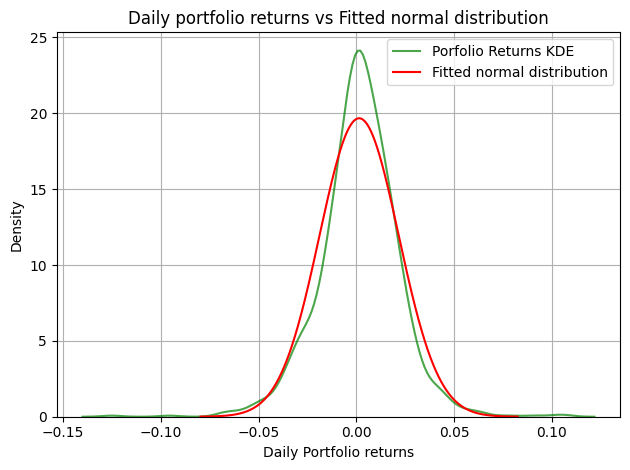

In [21]:
returns = data.pct_change().dropna()

# Portfolio weights (equal weights as example)
weights = np.array([1/len(tickers)] * len(tickers))

# Portfolio daily returns -
portfolio_returns = returns.dot(weights)
mean = portfolio_returns.mean()
std_dev = portfolio_returns.std()
import seaborn as sns
sns.kdeplot(portfolio_returns, color='green', fill=False, alpha=0.7, label='Porfolio Returns KDE')
from scipy.stats import norm
x=np.linspace(mean-4*std_dev,mean+4*std_dev,1000)
plt.plot(x,norm.pdf(x, mean, std_dev),'r-', label='Fitted normal distribution')
plt.title('Daily portfolio returns vs Fitted normal distribution')
plt.xlabel('Daily Portfolio returns')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## It looks like a bad fit, but notice that it fits the tails well. The left tails is what matters to us.

=== Portfolio Risk Metrics with Normal distribution (95% confidence) ===
Historical VaR: -0.0316
Parametric VaR: -0.0319
Monte Carlo VaR: -0.0321
Conditional VaR (CVaR): -0.0452


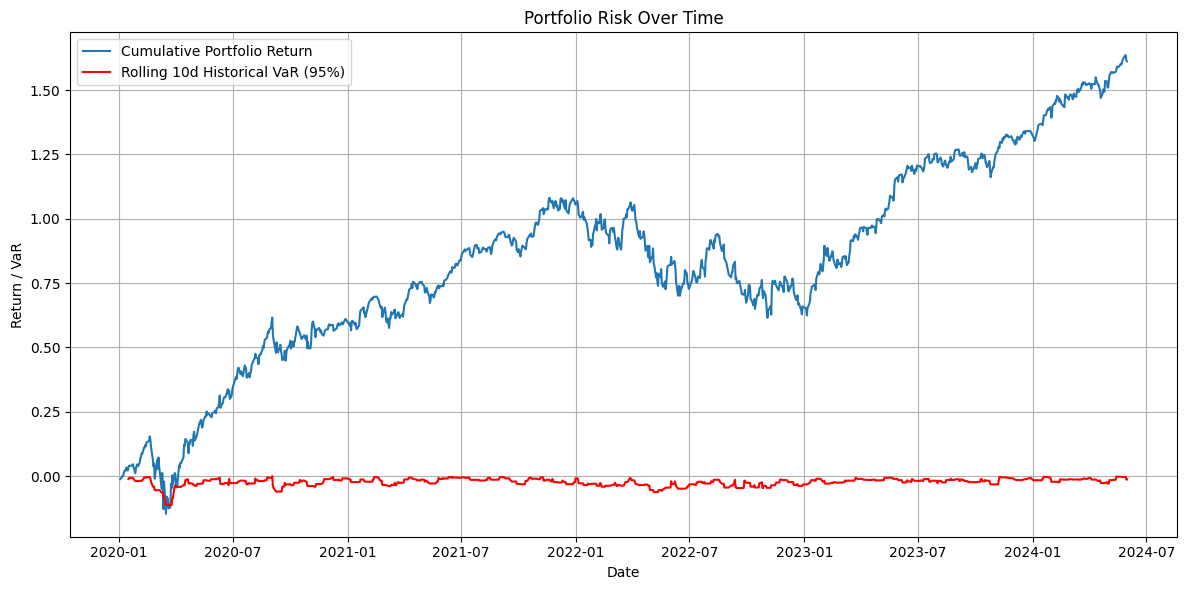

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats


confidence_level=0.95
#  Historical VaR 
hist_VaR = np.percentile(portfolio_returns, (1-confidence_level)*100) #Note: Historical VaR doesnt depend on the distribution

#  Parametric VaR (Variance-Covariance, assuming normality) 

param_VaR = stats.norm.ppf(1 - confidence_level, mean, std_dev)

#  Monte Carlo VaR (simulate 10,000 scenarios) 
n_simulations = 10000
simulated_returns = np.random.normal(mean, std_dev, n_simulations)
mc_VaR = np.percentile(simulated_returns, (1-confidence_level)*100)

#  Conditional VaR (CVaR) 
CVaR = portfolio_returns[portfolio_returns <= hist_VaR].mean()

# Print results
print(f"=== Portfolio Risk Metrics with Normal distribution ({confidence_level*100:.0f}% confidence) ===")
print(f"Historical VaR: {hist_VaR:.4f}")
print(f"Parametric VaR: {param_VaR:.4f}")
print(f"Monte Carlo VaR: {mc_VaR:.4f}")
print(f"Conditional VaR (CVaR): {CVaR:.4f}")

# Visualization: rolling historical VaR over time 
window = 10  # 60-day rolling window
rolling_VaR = portfolio_returns.rolling(window).apply(
    lambda x: np.percentile(x, (1-confidence_level)*100), raw=False
)

plt.figure(figsize=(12,6))
plt.plot(portfolio_returns.index, portfolio_returns.cumsum(), label='Cumulative Portfolio Return')
plt.plot(rolling_VaR, label=f'Rolling {window}d Historical VaR ({confidence_level*100:.0f}%)', color='red')
plt.title('Portfolio Risk Over Time')
plt.xlabel('Date')
plt.ylabel('Return / VaR')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [23]:
returns.min()

AAPL   -0.128647
MSFT   -0.147390
GOOG   -0.111008
NVDA   -0.184521
AMZN   -0.140494
dtype: float64

In [24]:
from scipy.stats import shapiro
stat, p_value = shapiro(portfolio_returns)
print(f"Shapiro-Wilk p-value: {p_value:.4f}")


Shapiro-Wilk p-value: 0.0000


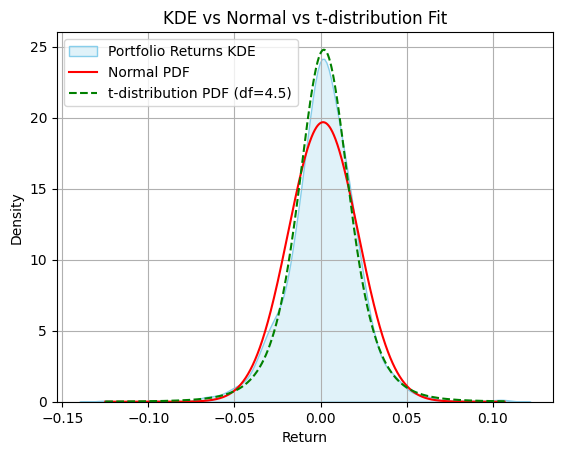

In [38]:
from scipy.stats import t

# Fit a t-distribution to portfolio returns
df, _, _ = t.fit(portfolio_returns)

# Compare fit with KDE and normal
x = np.linspace(portfolio_returns.min(), portfolio_returns.max(), 1000)

sns.kdeplot(portfolio_returns, fill=True, color='skyblue', label='Portfolio Returns KDE')
plt.plot(x, norm.pdf(x, loc=mean, scale=std_dev), 'r-', label='Normal PDF')
plt.plot(x, t.pdf(x, df, loc=loc, scale=scale), 'g--', label=f't-distribution PDF (df={df:.1f})')

plt.title("KDE vs Normal vs t-distribution Fit")
plt.xlabel("Return")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()


## The t-distribution is a much better fit the stock prices! Lets recompute everything(except Historical VaR)

In [39]:
#  Parametric VaR (Variance-Covariance, assuming t) 
param_VaR_t = stats.t.ppf(1 - confidence_level, df, loc, scale)

#  Monte Carlo VaR (simulate 10,000 scenarios) 
n_simulations = 10000
simulated_returns = loc + scale * np.random.standard_t(df, size=n_simulations)
mc_VaR_t = np.percentile(simulated_returns, (1-confidence_level)*100)

t_CVaR = simulated_returns[simulated_returns <= mc_VaR_t].mean()

# Print results
print(f"=== Portfolio Risk Metrics with t-distribution ({confidence_level*100:.0f}% confidence) ===")
print(f"Parametric VaR_t: {param_VaR_t:.4f}")
print(f"Monte Carlo VaR_t: {mc_VaR_t:.4f}")
print(f"Monte Carlo CVaR (95%): {t_CVaR:.4f}")



=== Portfolio Risk Metrics with t-distribution (95% confidence) ===
Parametric VaR_t: -0.0296
Monte Carlo VaR_t: -0.0304
Monte Carlo CVaR (95%): -0.0453


## The VaR values are actually slightly higher, but the CVaR is same. It doesnt seem that we have captured any more tail risk

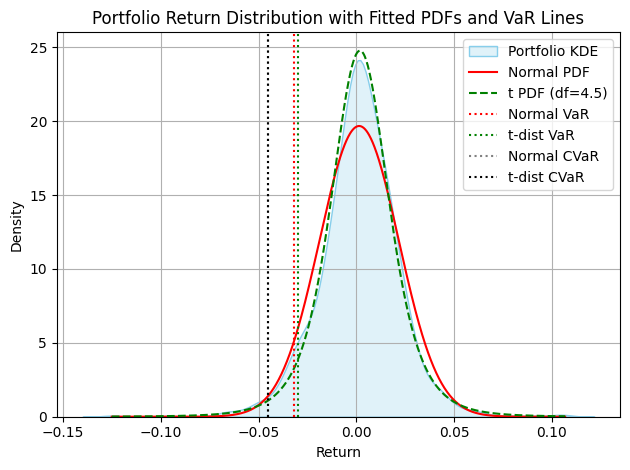

In [40]:
# Dashboard plot
x = np.linspace(portfolio_returns.min(), portfolio_returns.max(), 1000)
sns.kdeplot(portfolio_returns, fill=True, color='skyblue', label='Portfolio KDE')
plt.plot(x, norm.pdf(x, loc=mean, scale=std_dev), 'r-', label='Normal PDF')
plt.plot(x, t.pdf(x, df, loc=loc, scale=scale), 'g--', label=f't PDF (df={df:.1f})')

# VaR lines
plt.axvline(param_VaR, color='red', linestyle=':', label='Normal VaR')
plt.axvline(param_VaR_t, color='green', linestyle=':', label='t-dist VaR')
plt.axvline(CVaR,color='grey', linestyle=':', label = 'Normal CVaR')
plt.axvline(t_CVaR,color='black', linestyle=':', label = 't-dist CVaR')

plt.title('Portfolio Return Distribution with Fitted PDFs and VaR Lines')
plt.xlabel('Return')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Summary:
### Analyzed historical returns from a portfolio of large-cap tech stocks and fitted both a normal distribution and a Student’s t-distribution to the portfolio’s daily returns.

### The t-distribution provided a visibly better overall fit to the empirical return distribution (as seen from KDE comparison), especially capturing the peak and moderate tails more accurately.

### However, both distributions fit the extreme left tail similarly well, which is the region that determines Value at Risk (VaR).

### As a result, the VaR estimates at the 95% confidence level were very close between the normal and t-distributions.